# Большая лабораторная работа

## Актуальный код

Импортируем бибилотеки

In [1]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
from imageio import imread, imsave
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.filters import gaussian
from skimage.filters import try_all_threshold
from skimage.filters import threshold_otsu, threshold_triangle, rank
from skimage.measure import label, regionprops
from skimage.morphology import binary_closing
from skimage.morphology import binary_opening
from skimage.morphology import disk
from skimage.transform import (hough_line, hough_line_peaks, probabilistic_hough_line)
from skimage.util import img_as_ubyte

In [2]:
data_path = "./Data 1"

Мы предполагаем, что все фотографии находятся именно в указанном каталоге, который не содержит других подпапок или чего-то другого. Все изображения имеют название вида [метка]_[номер].jpg

In [3]:
def get_images_list(path):
    folder = []
    for _, _, files in os.walk(path):
        folder.append(files)
    return folder[0]

### Границы двери
С помощью преобразования Хафа в функции `find_door_boundaries` ищем левую и правую границы двери. При этом убираем все не вертикальные найденные линии (это те, у которых `angle > 1 or angle < -1`). А среди всех оставшихся линий левой границей двери является линия, у которой минимальный `dist`, а правой границей - у которой максимальный `dist`.

In [4]:
def find_door_boundaries(img):
    img_blur = gaussian(img, sigma=3.0, multichannel=True)
    img_blur_gray = rgb2gray(img_blur)
    thresh_otsu = threshold_otsu(img_blur_gray)
    img_tmp = img_blur_gray <= thresh_otsu
    
    h, theta, d = hough_line(canny(img_tmp, sigma=2.0)) # вычисляем преобразование Хаффа от границ изображения

    door_lines = []
    dist_lines = []
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        if angle > 1 or angle < -1: # не вертикальная линия
            continue
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - img_tmp.shape[1] * np.cos(angle)) / np.sin(angle)
        door_lines.append((y0, y1))
        dist_lines.append(dist)
    
    left = door_lines[dist_lines.index(min(dist_lines))]
    right = door_lines[dist_lines.index(max(dist_lines))]
    
    return left, right

### Поиск стула

Функция `get_largest_component` анализирует компоненты свзяности по маске.

In [5]:
def get_largest_component(mask):
    labels = label(mask) # разбиение маски на компоненты связности
    props = regionprops(labels) # нахождение свойств каждой области (положение центра, площадь, bbox, интервал интенсивностей и т.д.)
    areas = [prop.area for prop in props] # нас интересуют площади компонент связности

    #print("Значения площади для каждой компоненты связности: {}".format(areas))
    largest_comp_id = np.array(areas).argmax() # находим номер компоненты с максимальной площадью

    #print("labels - матрица, заполненная индексами компонент связности со значениями из множества: {}".format(np.unique(labels)))
    return labels == (largest_comp_id + 1) # области нумеруются с 1, поэтому надо прибавить 1 к индексу

С помощью функции `find_chair_boundaries` и анализа компонент связности пытаемся отыскать стул.

In [6]:
def find_chair_boundaries(img):
    img_blur_gray = rgb2gray(gaussian(img, sigma=1.0, multichannel=True))
    thresh_otsu = threshold_otsu(img_blur_gray)
    res_otsu = img_blur_gray <= thresh_otsu
    res_otsu_enclosed = binary_opening(res_otsu, selem=np.ones((40, 40)))
    result_mask_chair = get_largest_component(res_otsu_enclosed)
    
    top = result_mask_chair.shape[0]
    bottom = 0
    for row in range(result_mask_chair.shape[0]):
        if result_mask_chair[row, :].sum() > 0:
            top = min(top, row)
            bottom = max(bottom, row)

    left = result_mask_chair.shape[1]
    right = 0
    for col in range(result_mask_chair.shape[1]):
        if result_mask_chair[:, col].sum() > 0:
            left = min(left, col)
            right = max(right, col)

    vertical_indices = np.where(np.any(result_mask_chair, axis=1))[0]
    horizontal_indices = np.where(np.any(result_mask_chair, axis=0))[0]

    corner = (horizontal_indices[0], vertical_indices[0])
    width = horizontal_indices[-1] - horizontal_indices[0]
    hight = vertical_indices[-1] - vertical_indices[0]

    return corner, width, hight

Пара вспомогательных функций для работы с прямыми линиями. В функции `line_equation` находим коэффициенты прямой `k` и `b`. В функции `point_on_line` находим на прямой с кооэффициентами `k` и `b` координату `x`, зная координату `y`.

In [7]:
def line_equation(point1, point2):
    # equation of a straight line on two points
    k = (point1[1] - point2[1]) / (point1[0] - point2[0])
    b = point2[1] - k * point2[0]
    return k, b

In [8]:
def point_on_line(y, k, b):
    # y = k * x + b  =>  x = (y - b) / k 
    return (y - b) / k

### Основная работа

Process image no_01.jpg


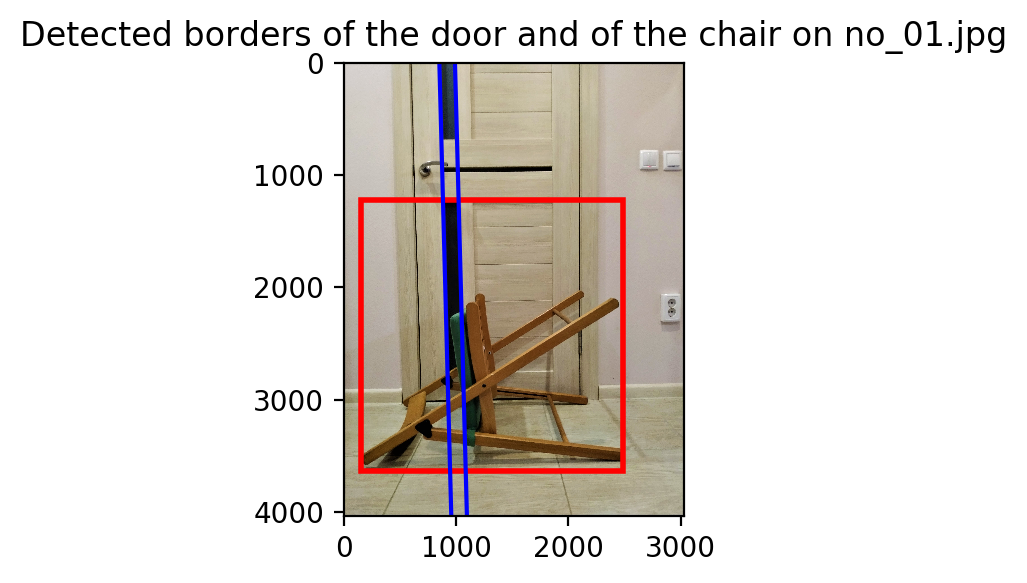

Door width = 139.0620
Chair width = 2333.0000
no_01.jpg => No
Process image no_02.jpg


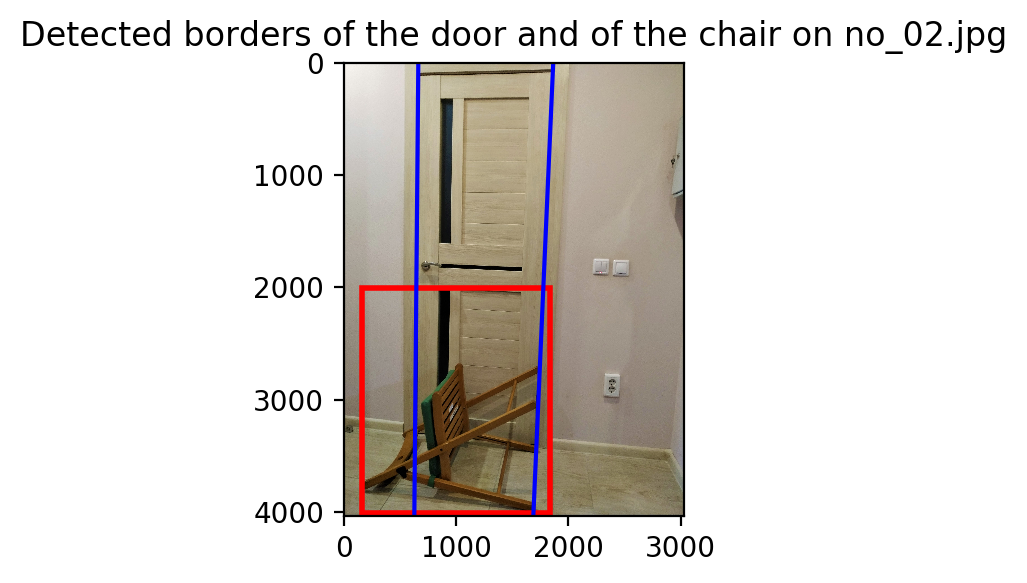

Door width = 1130.2423
Chair width = 1672.0000
no_02.jpg => No
Process image no_06.jpg


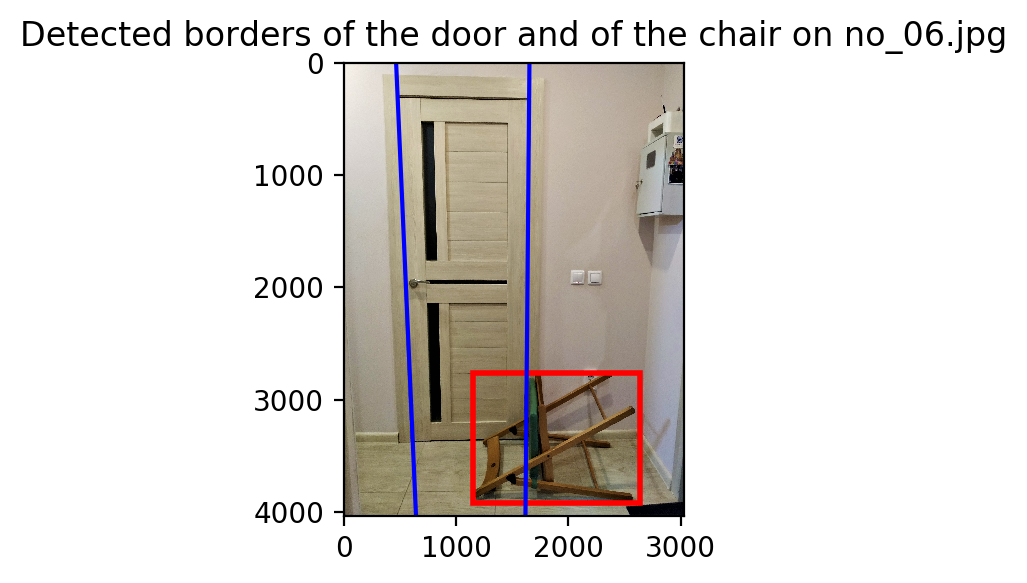

Door width = 1041.1759
Chair width = 1480.0000
no_06.jpg => No
Process image yes_01.jpg


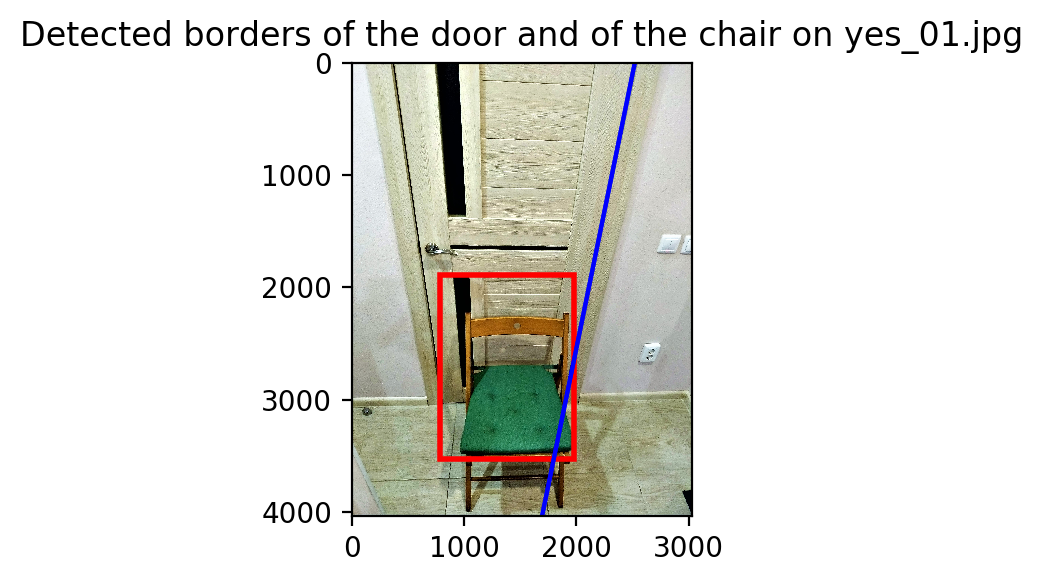

Door width = 0.0000
Chair width = 1194.0000
yes_01.jpg => No
Process image yes_02.jpg


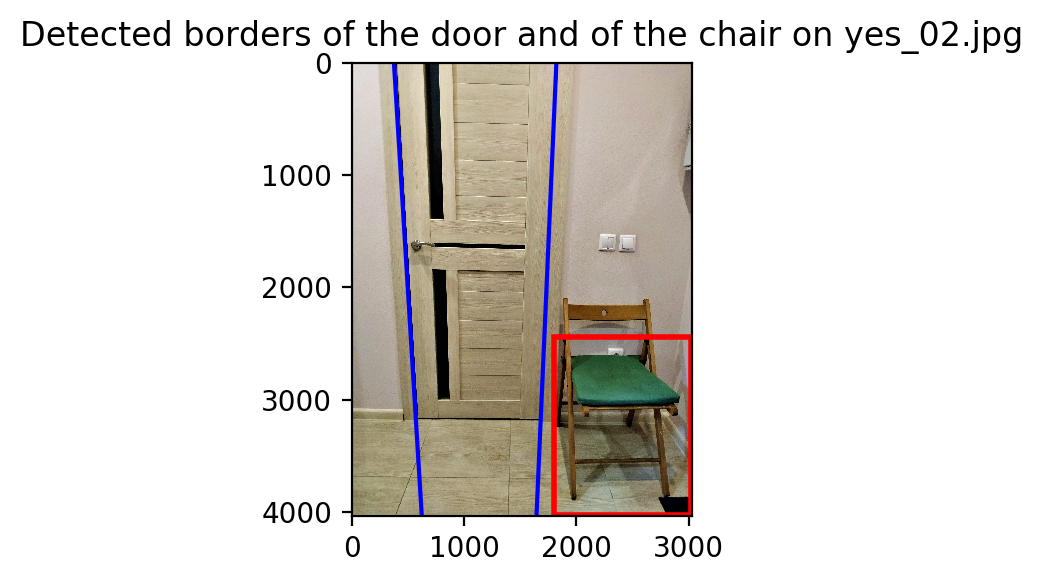

Door width = 1188.9874
Chair width = 1221.0000
yes_02.jpg => No
Process image yes_03.jpg


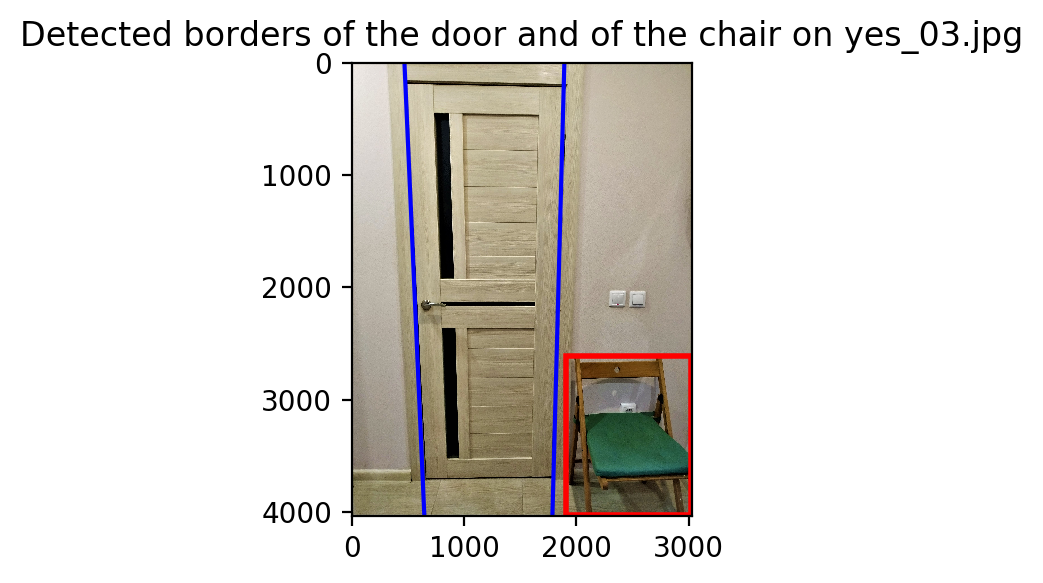

Door width = 1240.0960
Chair width = 1113.0000
yes_03.jpg => Yes
Process image yes_04.jpg


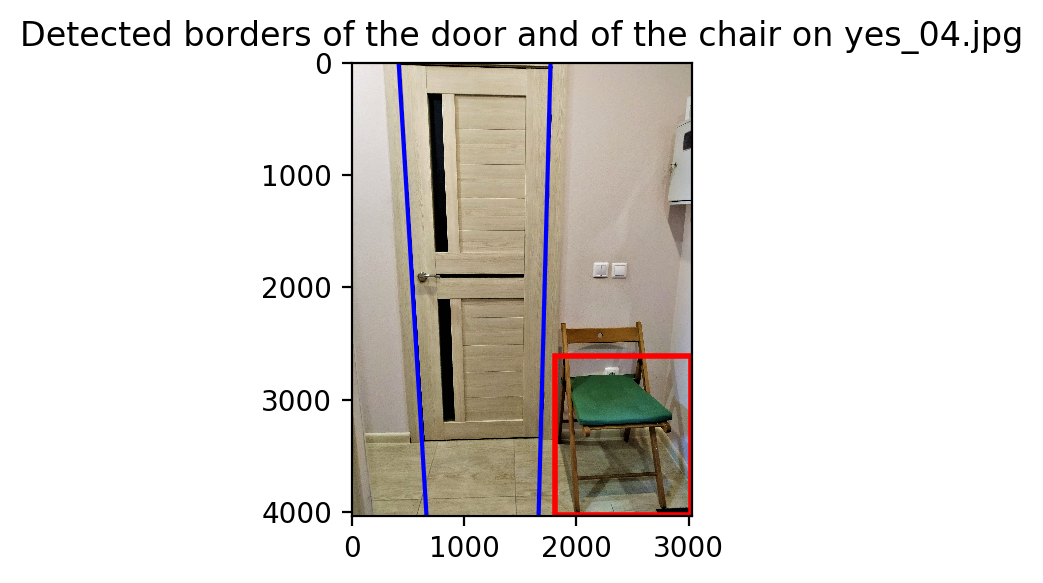

Door width = 1122.7922
Chair width = 1215.0000
yes_04.jpg => No
Process image yes_06.jpg


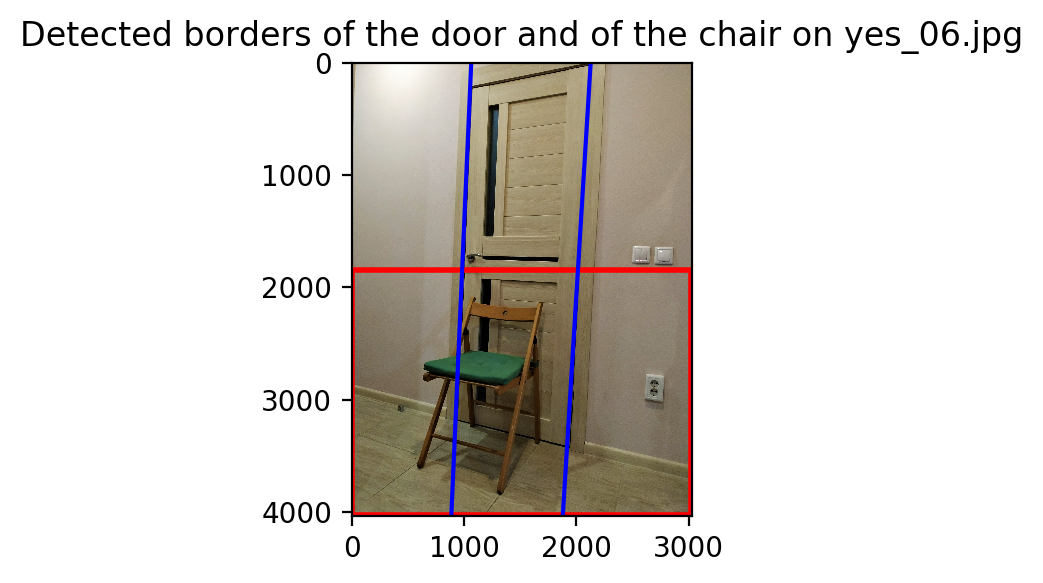

Door width = 1030.5503
Chair width = 3023.0000
yes_06.jpg => No
Process image yes_13.jpg


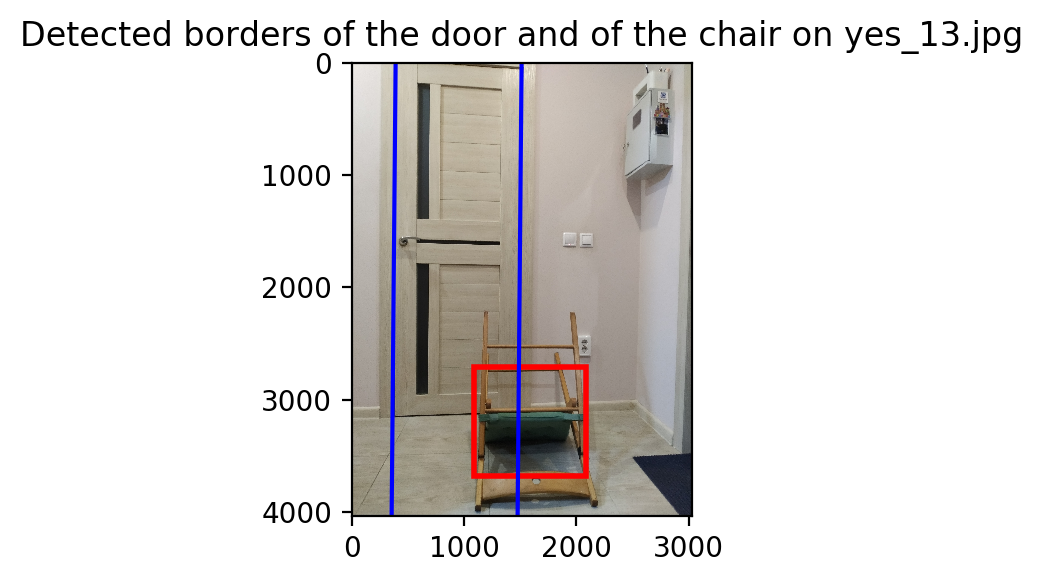

Door width = 1121.1544
Chair width = 993.0000
yes_13.jpg => Yes
Process image yes_22.jpg


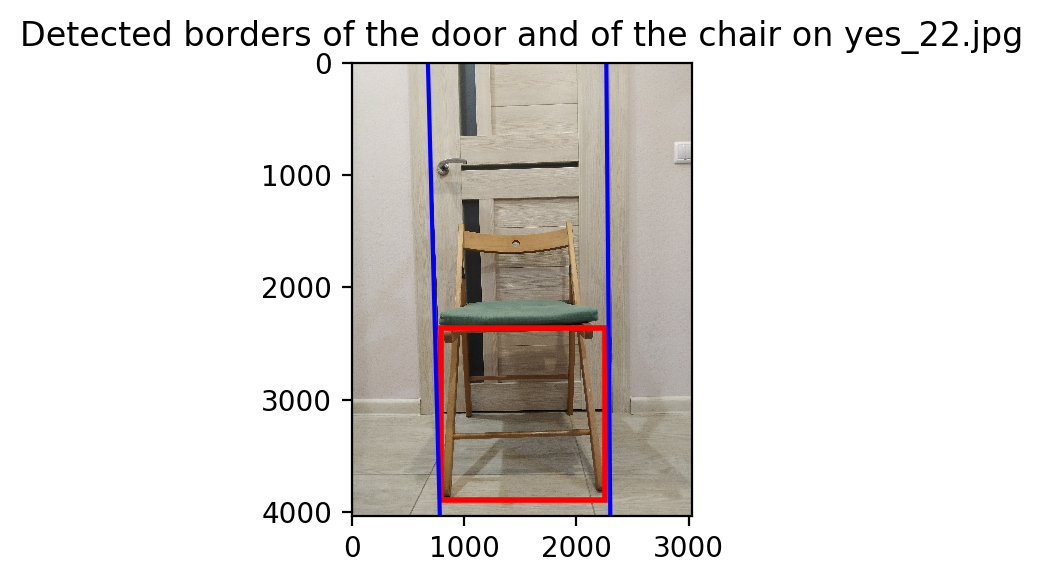

Door width = 1546.4709
Chair width = 1452.0000
yes_22.jpg => Yes
-------------------------------
['no_01.jpg => No', 'no_02.jpg => No', 'no_06.jpg => No', 'yes_01.jpg => No', 'yes_02.jpg => No', 'yes_03.jpg => Yes', 'yes_04.jpg => No', 'yes_06.jpg => No', 'yes_13.jpg => Yes', 'yes_22.jpg => Yes']
Total number: 10
The number of correctly defined: 6
Percentage of accuracy: 60.0000


In [9]:
img_dataset_name = get_images_list(data_path)
num_correct = 0
result = []
for img_name in img_dataset_name:
    print("Process image %s" % img_name)
    img = imread(os.path.join(data_path, img_name))

    door_left, door_right = find_door_boundaries(img)
    chair_corner, chair_width, chair_height = find_chair_boundaries(img)
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    fig.set_dpi(200)
    
    ax.imshow(img)
    ax.plot((0, img.shape[1]), door_left, '-b')
    ax.plot((0, img.shape[1]), door_right, '-b')
    ax.add_patch(Rectangle(chair_corner, chair_width, chair_height, linewidth=2, edgecolor='r', facecolor='none'))
    ax.set_xlim((0, img.shape[1]))
    ax.set_ylim((img.shape[0], 0))
    ax.set_title('Detected borders of the door and of the chair on %s' % img_name)
    
    plt.show()
    
    k_left, b_left = line_equation((0, door_left[0]), (img.shape[1], door_left[1]))
    k_right, b_right = line_equation((0, door_right[0]), (img.shape[1], door_right[1]))

    first_door_line_point = point_on_line(chair_corner[1], k_left, b_left)
    second_door_line_point = point_on_line(chair_corner[1], k_right, b_right)
    
    print("Door width = %.4f" % abs(first_door_line_point - second_door_line_point))
    print("Chair width = %.4f" % chair_width)
        
    if chair_width < abs(first_door_line_point  - second_door_line_point):
        if img_name.startswith("yes"):
            num_correct = num_correct + 1
        result.append(img_name + " => Yes")
        print(result[-1])
    else:
        if img_name.startswith("no"):
            num_correct = num_correct + 1
        result.append(img_name + " => No")
        print(result[-1])
        
        
print("-------------------------------")
num_total = len(img_dataset_name)
print(result)
print("Total number: %i" % num_total)
print("The number of correctly defined: %i" % num_correct)
print("Percentage of accuracy: %.4f" % (num_correct / num_total * 100))